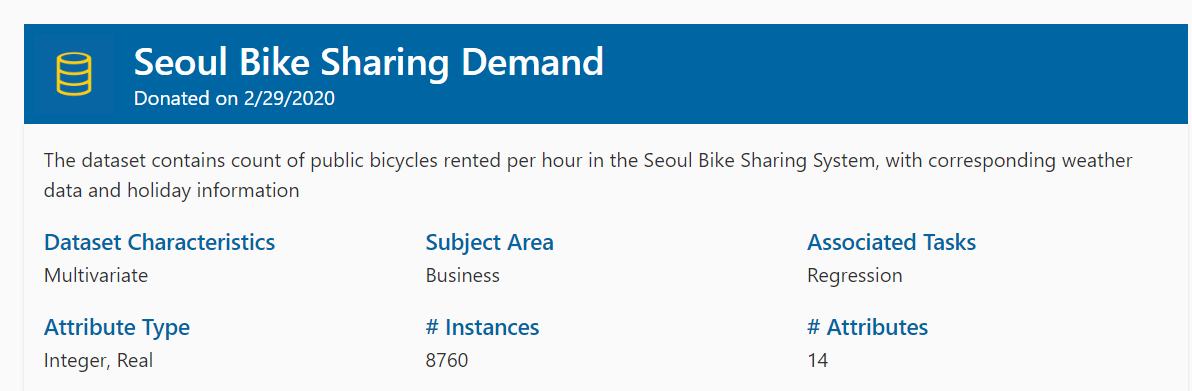

    

## Objectives

After completing this lab you will be able to:

* Use scikit-learn to implement Multiple Linear Regression
* Create a model, train it, test it and use the model


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#understanding-data">Understanding the Data</a></li>
        <li><a href="#reading_data">Reading the Data in</a></li>
        <li><a href="#multiple_regression_model">Multiple Regression Model</a></li>
        <li><a href="#prediction">Prediction</a></li>
        <li><a href="#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>


### Importing Needed packages


In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split

# metrics 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics

# suppress warnings
import warnings
warnings.filterwarnings("ignore")


<h2 id="understanding_data">Understanding the Data</h2>

### `SeoulBikeData.csv`:
Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes. 
The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information. [Dataset source](https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand)

<h2 id="reading_data">Reading the data in</h2>


In [28]:
import chardet
import pandas as pd

In [29]:
with open('SeoulBikeData.csv', 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large


df = pd.read_csv('SeoulBikeData.csv', encoding=result['encoding'])

In [30]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [31]:
# data shape
df.shape

(8760, 14)

In [32]:
# misssing values
df.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

In [33]:
# drop missing values
df_new = df.dropna()

In [34]:
# check the df_new for any missing values
df_new.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

In [35]:
# view names of columns
df_new.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [36]:
# drop the date column
df_new.drop(['Date'], axis = 1, inplace = True) 

### Let's select some features that we want to use for regression.


In [37]:
# create a list of subset features for the first 7 konw to predict the Total interactions
full_features = ['Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day']

Our goal is to predict the 'Rented Bike Count'.

In [38]:
# full features
print('List of full features: ', full_features)

List of full features:  ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day']


### Now let's plot a correlation matrix to see if there's any multicolinearity.

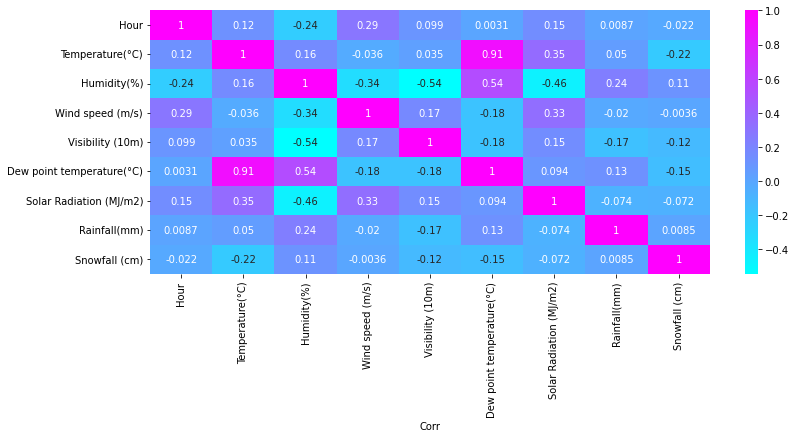

In [39]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(df_new[full_features].corr(), annot=True,cmap=plt.cm.cool)
plt.tight_layout()
plt.xlabel('Corr')
plt.show()

**Note:** if you take a look at the correlation matrix plot you'll find out that there's is strong correlation between 'temperature' and 'Dew point temperature(C)'.

#### Creating train and test dataset
Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set. 
This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the model. Therefore, it gives us a better understanding of how well our model generalizes on new data.

We know the outcome of each data point in the testing dataset, making it great to test with! Since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing.

Let's split our dataset into train and test sets. Around 80% of the entire dataset will be used for training and 20% for testing. We create a mask to select random rows using the  __np.random.rand()__ function: 


### Let us dummy econde categorical variable

In [69]:
# dummy encode 'Seasons', 'Holiday', 'Functioning Day
df_dum = pd.get_dummies(df_new, columns=['Seasons', 'Holiday', 'Functioning Day'], drop_first=True)

In [70]:
df_dum.shape

(8760, 15)

### Training Data and Test Data

Now, we set our 'features' or x values and our Y or target variable.


In [71]:
df_dum = df_dum.astype(float)

In [72]:
features = df_dum.drop(columns='Rented Bike Count', axis=1)
Y = df_dum['Rented Bike Count']

In [73]:
features

,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Functioning Day_Yes
0,0.0,-5.2,37.0,2.2,2000.0,-17.6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,1.0,-5.5,38.0,0.8,2000.0,-17.6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,2.0,-6.0,39.0,1.0,2000.0,-17.7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,3.0,-6.2,40.0,0.9,2000.0,-17.6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,4.0,-6.0,36.0,2.3,2000.0,-18.6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,19.0,4.2,34.0,2.6,1894.0,-10.3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8756,20.0,3.4,37.0,2.3,2000.0,-9.9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8757,21.0,2.6,39.0,0.3,1968.0,-9.9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8758,22.0,2.1,41.0,1.0,1859.0,-9.8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


### Train test split the dataset

In [74]:
x_train, x_test, y_train, y_test = train_test_split(features, Y, test_size=0.2, random_state=10)

**Scale the values:**    

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

<h2 id="multiple_regression_model">Multiple Regression Model</h2>


In [76]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit (x_train, y_train)

LinearRegression()

### Metrics:

In [77]:
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [ 189.25834198  179.89521169 -229.45597665   23.33733587    9.67413073
  167.69972378  -73.78528926  -62.98743215   18.54627763  -58.33790236
  -68.88115174 -156.50386537   24.62863608  163.98588879]


In [78]:
predictions = regr.predict(x_test)
predictions[:5]

array([  -9.73634014,  992.74716143, 1024.6031465 , 1108.5672153 ,
        564.9147878 ])

In [79]:
# calculatin the metrics 
LinearRegression_MAE = metrics.mean_absolute_error(y_test,predictions)
LinearRegression_MSE = metrics.mean_squared_error(y_test,predictions)
LinearRegression_RMSE = (LinearRegression_MSE)**0.5
LinearRegression_R2 = metrics.r2_score(y_test,predictions)

In [80]:
# dictionary for the dataframe
metric = {
  "MAE": [LinearRegression_MAE],
  "MSE": [LinearRegression_MSE],
  "RMSE": [LinearRegression_RMSE],
  "R2" : [LinearRegression_R2],
}

In [81]:
Report = pd.DataFrame(metric)
Report = Report.rename(index={0:'Linear Regression'})
Report

,MAE,MSE,RMSE,R2
Linear Regression,318.88402,178535.387537,422.534481,0.560321


## Further readings:
As mentioned before, __Coefficient__ and __Intercept__  are the parameters of the fitted line. 
Given that it is a multiple linear regression model with 7 parameters and that the parameters are the intercept and coefficients of the hyperplane, sklearn can estimate them from our data. Scikit-learn uses plain Ordinary Least Squares method to solve this problem.

#### Ordinary Least Squares (OLS)
OLS is a method for estimating the unknown parameters in a linear regression model. OLS chooses the parameters of a linear function of a set of explanatory variables by minimizing the sum of the squares of the differences between the target dependent variable and those predicted by the linear function. In other words, it tries to minimizes the sum of squared errors (SSE) or mean squared error (MSE) between the target variable (y) and our predicted output ($\hat{y}$) over all samples in the dataset.

OLS can find the best parameters using of the following methods:
* Solving the model parameters analytically using closed-form equations
* Using an optimization algorithm (Gradient Descent, Stochastic Gradient Descent, Newton’s Method, etc.)
